In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import *
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings 
warnings.filterwarnings('ignore')

/Users/namseoyong/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# train 데이터 불러오기
train = pd.read_csv('/Users/namseoyong/Desktop/WeatherBigData/train2.csv')

In [3]:
# test 데이터 불러오기
test = pd.read_csv('/Users/namseoyong/Desktop/WeatherBigData/test.csv')

In [4]:
# 데이터셋 크기 확인
train.shape, test.shape

((23208546, 44), (54503, 49))

<AxesSubplot:xlabel='insitu-TA', ylabel='Density'>

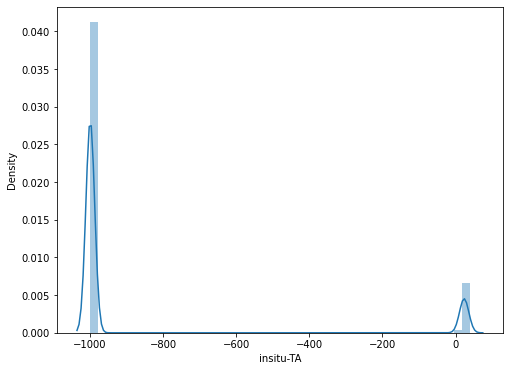

In [5]:
# target 피처 분포 확인
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['insitu-TA'])

<AxesSubplot:xlabel='isitu-LST', ylabel='Density'>

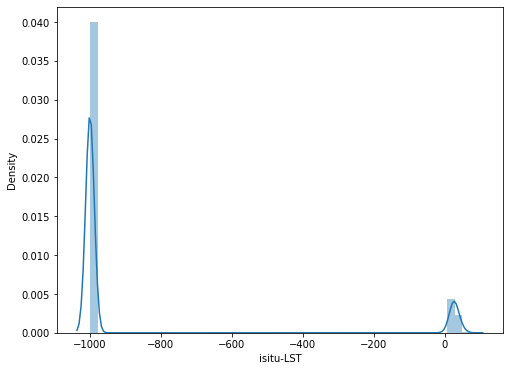

In [6]:
# target 피처 분포 확인
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['isitu-LST'])

In [7]:
data_features = list(test.columns)

In [8]:
# -999.0 제거
def get_null(x):
    if x == -999.0:
        x = None
    return x

In [9]:
# -999.0 None으로 바꾸기
for i in list(train.columns):
    train[i] = train[i].apply(lambda x : get_null(x))
for i in list(test.columns):
    test[i] = test[i].apply(lambda x : get_null(x))

<AxesSubplot:xlabel='insitu-TA', ylabel='Density'>

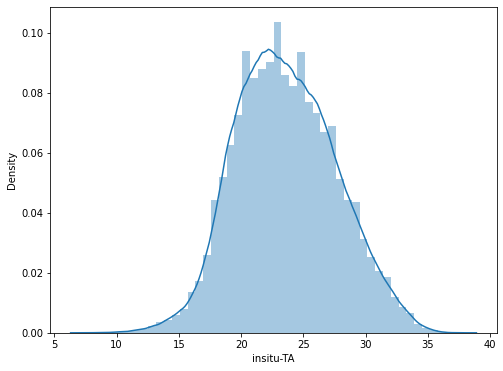

In [10]:
# target 피처 분포 확인
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['insitu-TA'])

<AxesSubplot:xlabel='isitu-LST', ylabel='Density'>

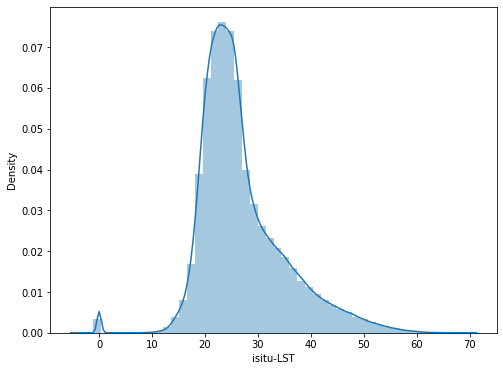

In [11]:
# target 피처 분포 확인
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['isitu-LST'])

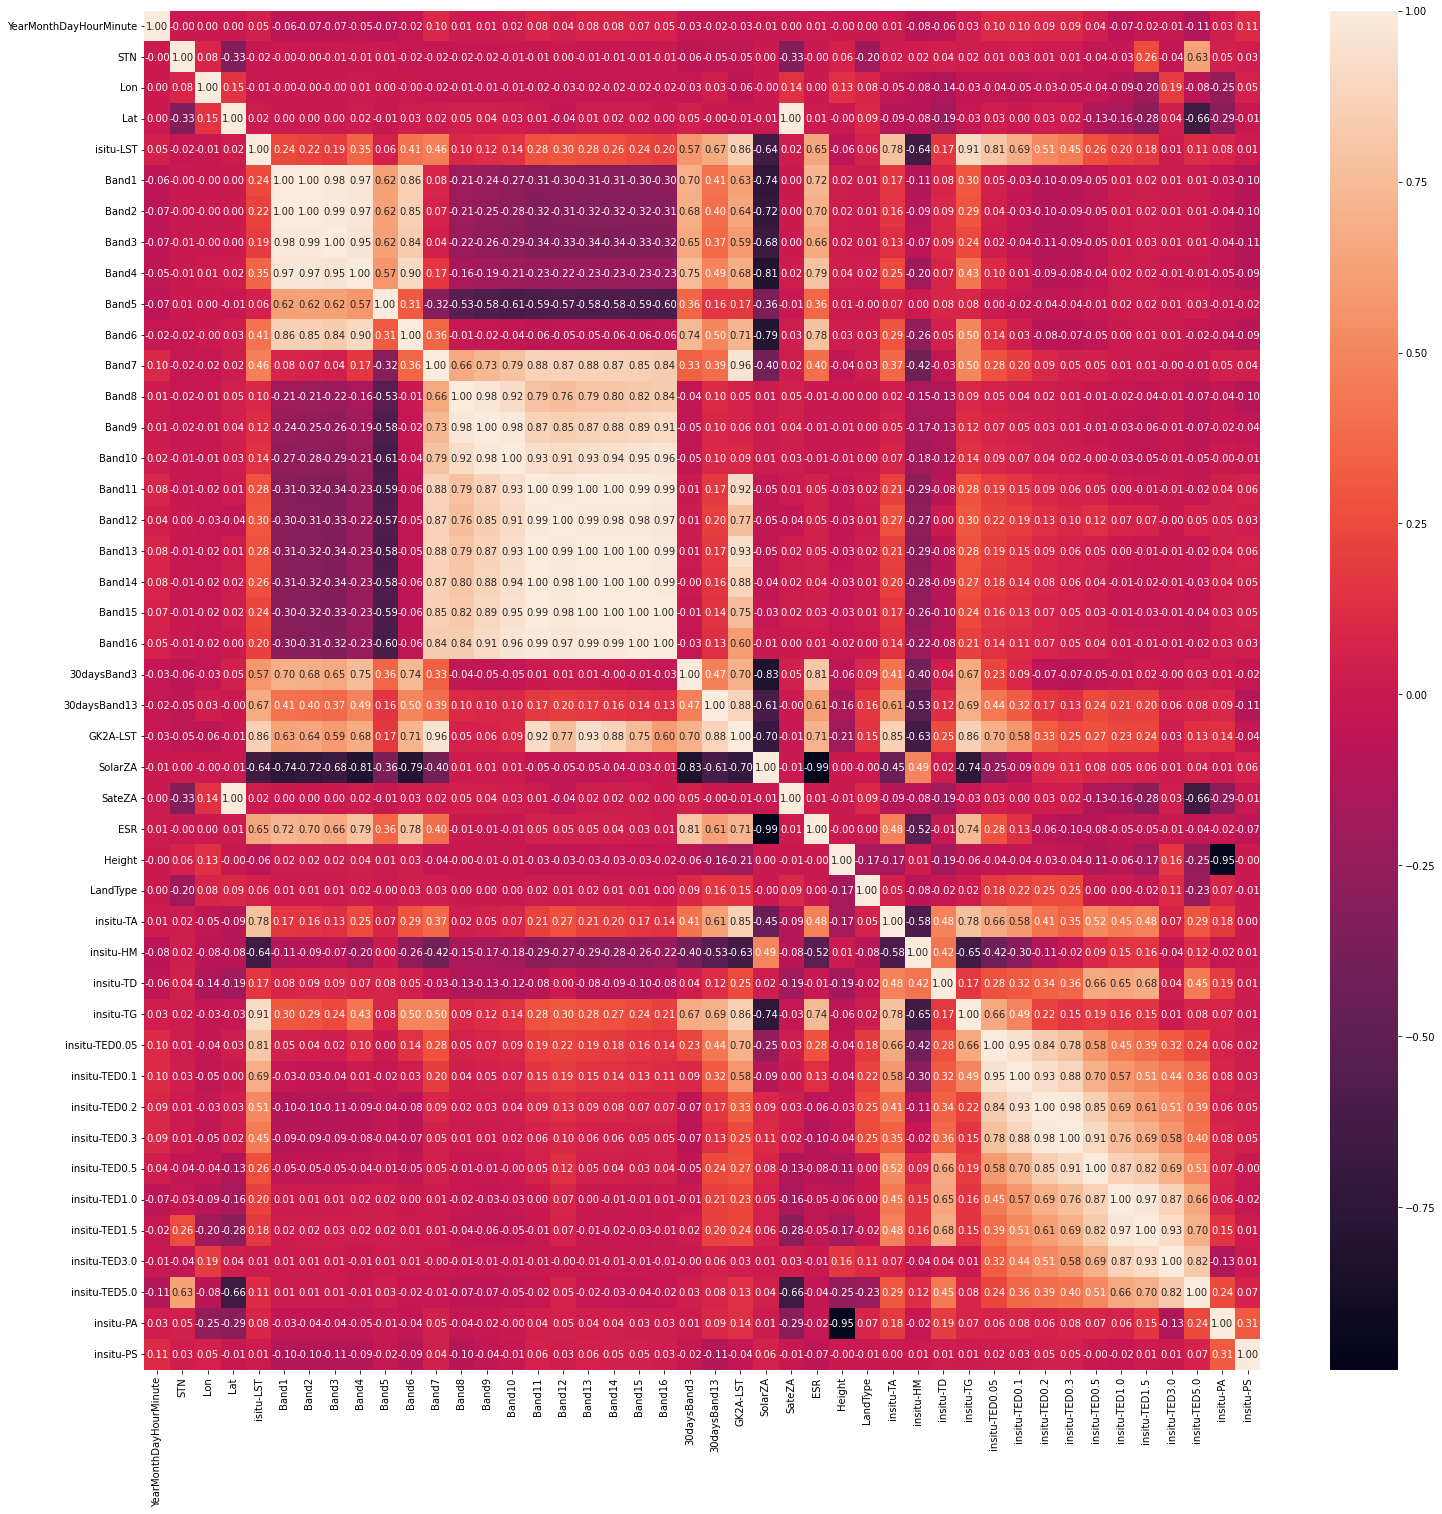

In [12]:
# 피처간의 상관계수 확인
corr_df = train.corr()
plt.figure(figsize=(25, 25))
sns.heatmap(corr_df, annot=True, fmt='.2f', cbar=True)
plt.show()

Text(0.5, 1.0, 'Total Missing Value (%)')

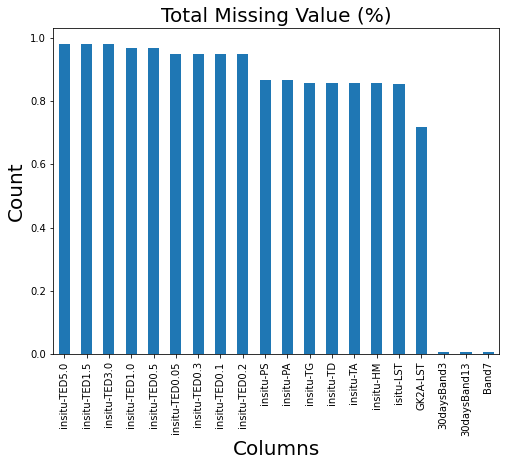

In [13]:
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

#histogram
#missing_data = missing_data.head(20)
percent_data = percent.head(20)
percent_data.plot(kind="bar", figsize = (8,6), fontsize = 10)
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.title("Total Missing Value (%)", fontsize = 20)

Text(0.5, 1.0, 'Total Missing Value (%)')

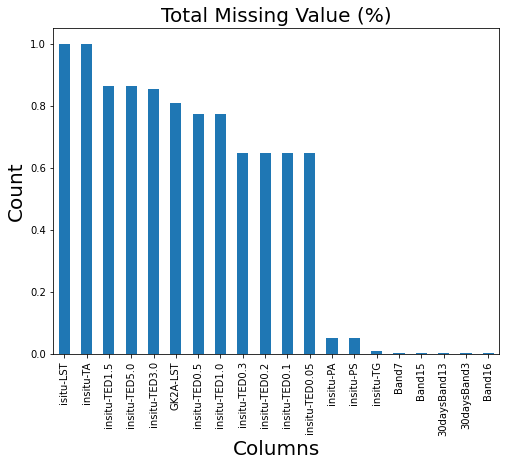

In [14]:
#missing data
total = test.isnull().sum().sort_values(ascending=False)
percent = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

#histogram
#missing_data = missing_data.head(20)
percent_data = percent.head(20)
percent_data.plot(kind="bar", figsize = (8,6), fontsize = 10)
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.title("Total Missing Value (%)", fontsize = 20)

In [15]:
# test 결측치 채우기
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer_mice = IterativeImputer(random_state=0)
test_impu = imputer_mice.fit_transform(test)
test_impu_df = pd.DataFrame(test_impu)
test_impu_df.insert(4, 'isitu-LST', 0)
test_impu_df.insert(29, 'insitu-LST', 0)
test_impu_df.columns = data_features

In [16]:
test = test_impu_df

In [17]:
# train 칼럼 drop
train.drop(['Band5','insitu-TED0.5', 'insitu-TED1.0', 'insitu-TED1.5', 'insitu-TED3.0', 'insitu-TED5.0'
           ,'Height', 'insitu-PA', 'insitu-PS', 'SateZA', 'YearMonthDayHourMinute'
           , 'Lon', 'Lat','STN', 'GK2A-LST', 'LandType', 'Band1','Band2', 'Band3', 'Band8', 'Band9', 'Band10' ,'Band15', 'Band16', 
            'insitu-TED0.1', 'insitu-TED0.2', 'insitu-TED0.3'], axis=1, inplace=True)

In [18]:
# test 칼럼 drop
test.drop(['Band5','insitu-TED0.5', 'insitu-TED1.0', 'insitu-TED1.5', 'insitu-TED3.0', 'insitu-TED5.0'
           ,'Height', 'insitu-PA', 'insitu-PS', 'SateZA', 'YearMonthDayHourMinute'
           , 'Lon', 'Lat','STN', 'GK2A-LST', 'LandType', 'year', 'month', 'day', 'hour', 'min',
          'Band1','Band2', 'Band3', 'Band8', 'Band9', 'Band10' ,'Band15', 'Band16', 
            'insitu-TED0.1', 'insitu-TED0.2', 'insitu-TED0.3'], axis=1, inplace=True)

In [19]:
train.shape, test.shape

((23208546, 17), (54503, 17))

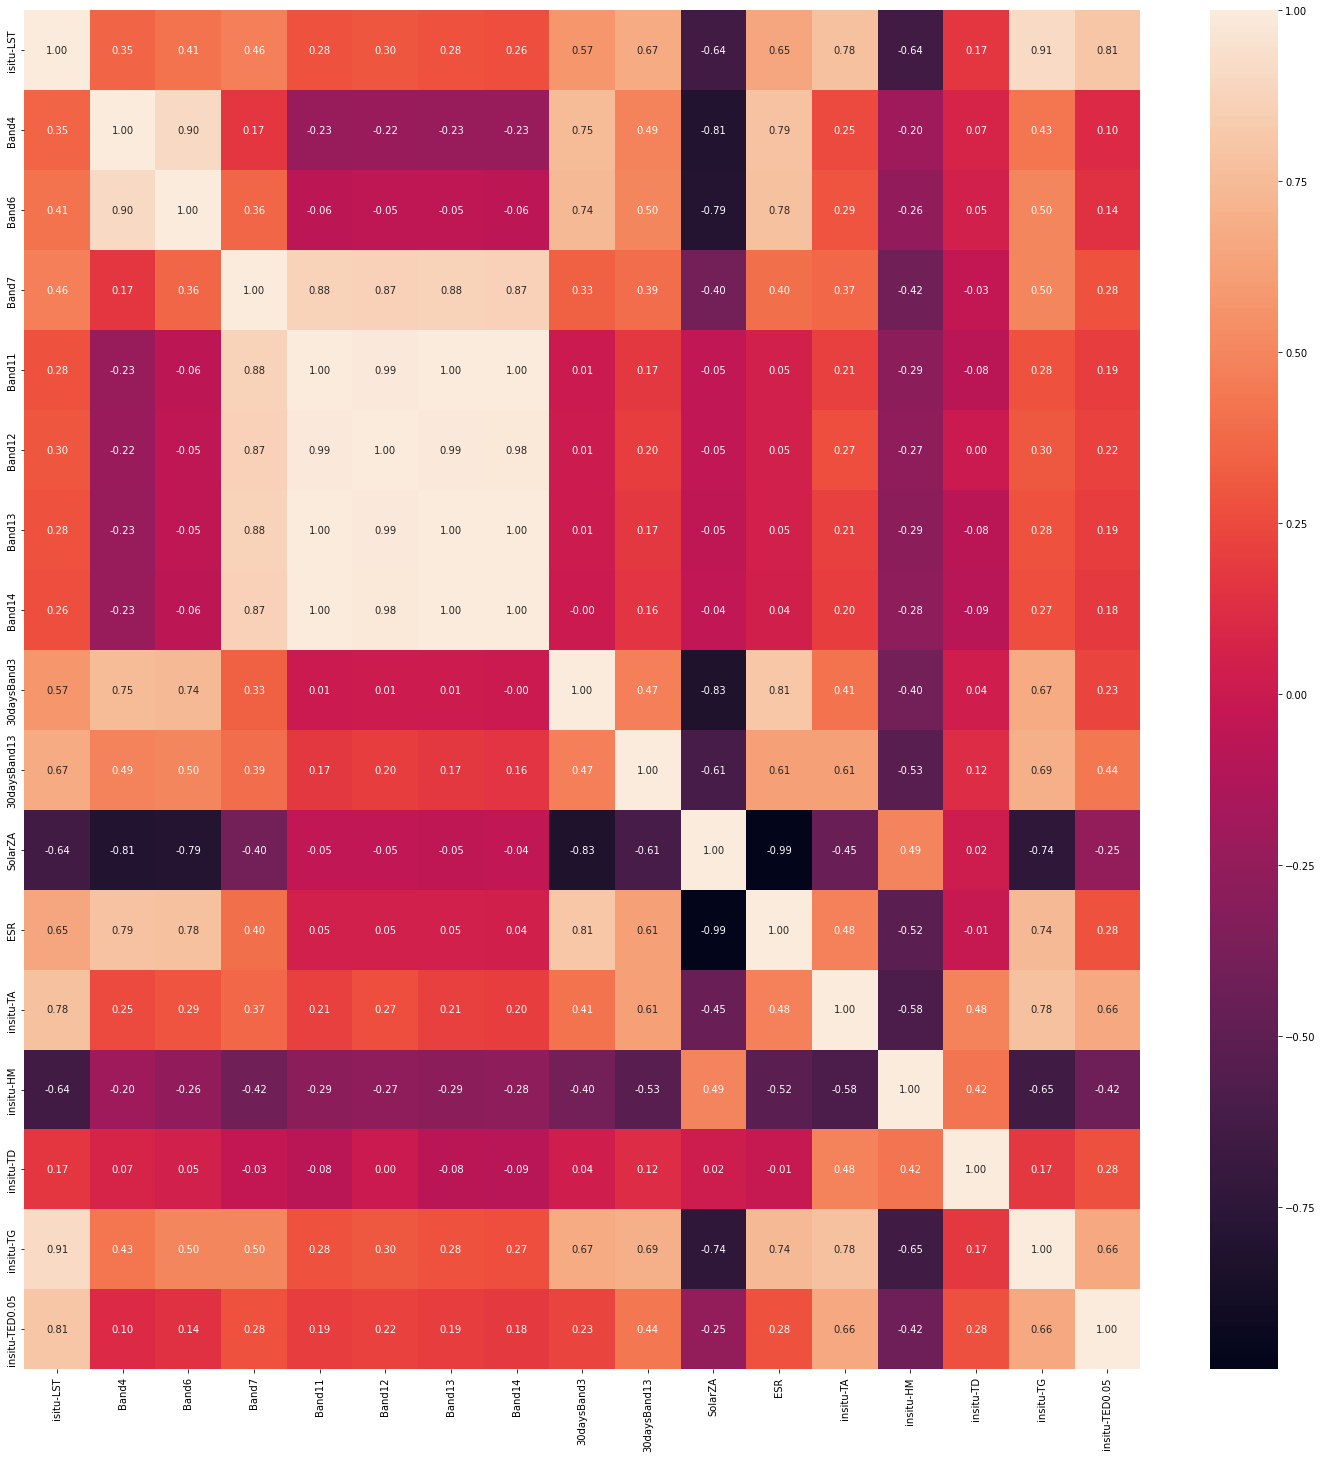

In [20]:
# 남은 feature들의 상관계수 확인
corr_df = train.corr()
plt.figure(figsize=(25, 25))
sns.heatmap(corr_df, annot=True, fmt='.2f', cbar=True)
plt.show()

In [21]:
# train 결측치 확인
train.isna().sum()

isitu-LST         19840961
Band4               198924
Band6               198924
Band7               198934
Band11              198924
Band12              198924
Band13              198924
Band14              198924
30daysBand3         203524
30daysBand13        203280
SolarZA                  0
ESR                      0
insitu-TA         19844350
insitu-HM         19843184
insitu-TD         19846423
insitu-TG         19908235
insitu-TED0.05    22015076
dtype: int64

In [22]:
# target 기준 결측치 drop
train.dropna(subset='insitu-TA', inplace=True)

In [23]:
train.shape, test.shape

((3364196, 17), (54503, 17))

In [24]:
# 결측치 평균으로 채우기
train.fillna(train.mean(), inplace=True)

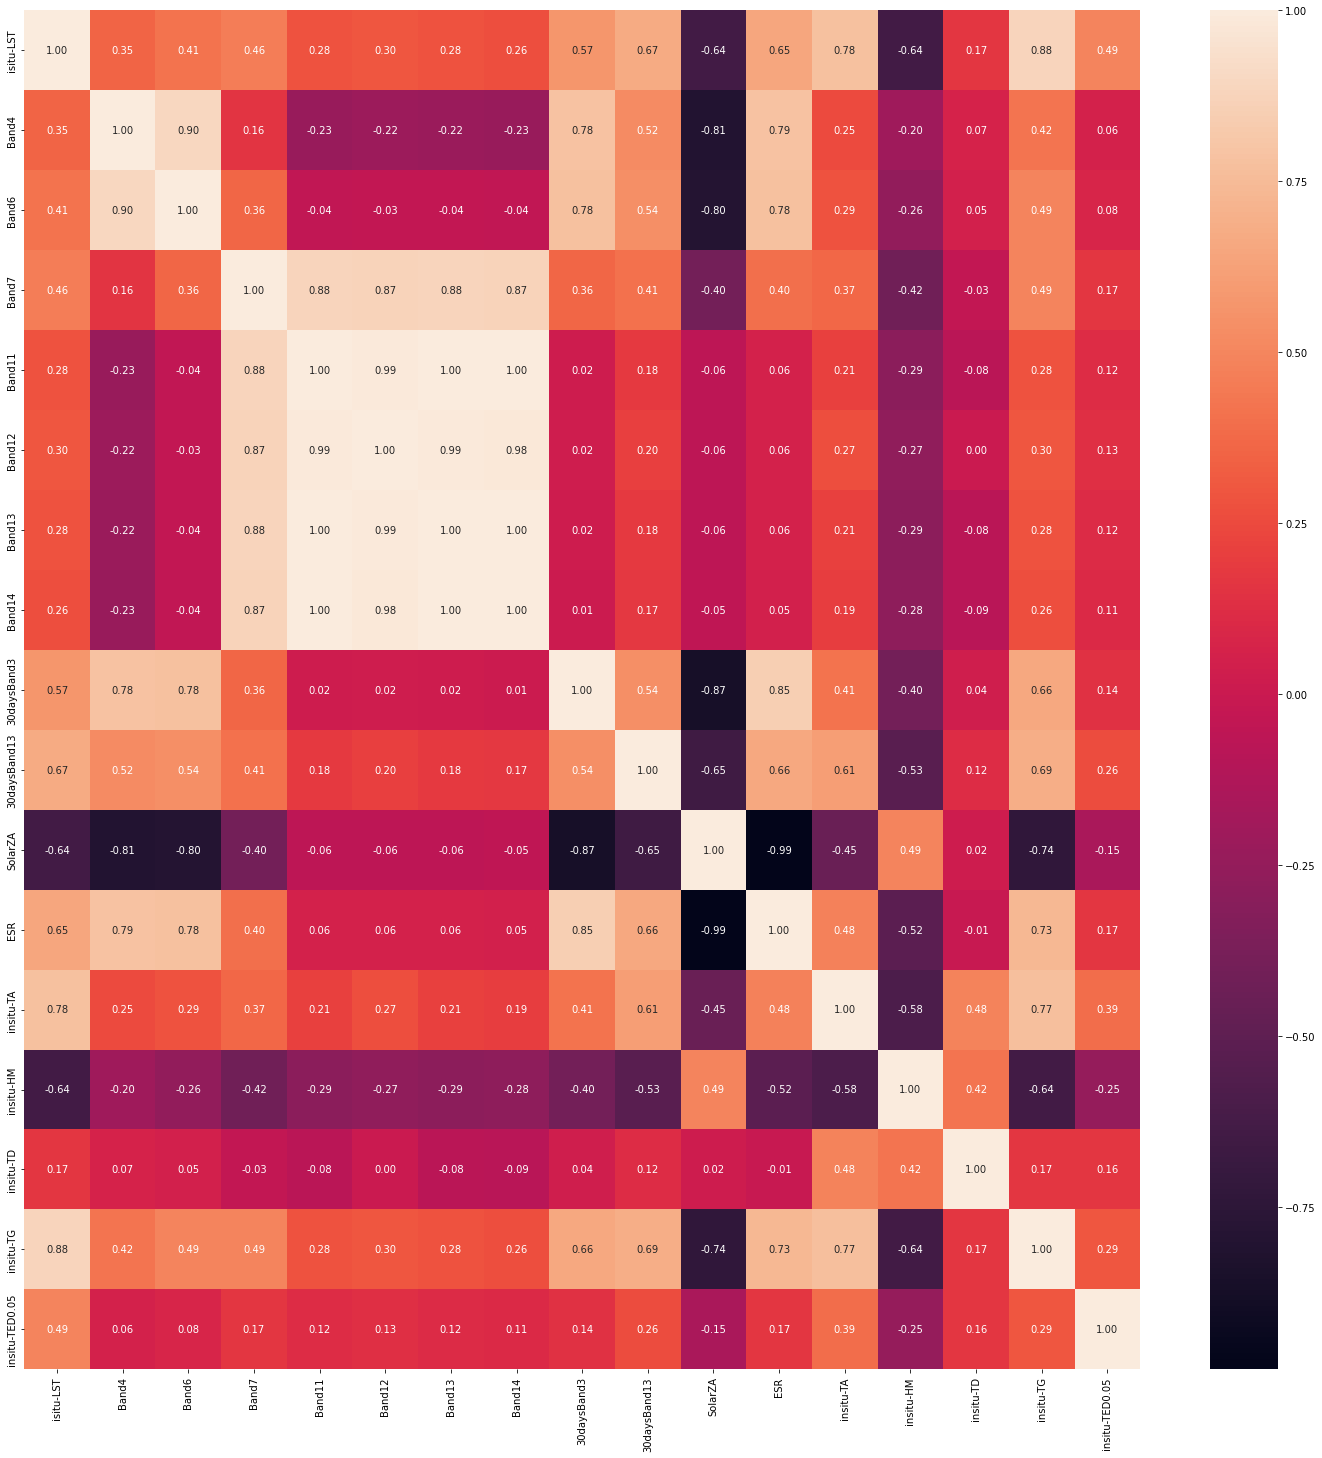

In [25]:
# 결측치 처리 후 피처 간의 상관계수 확인
corr_df = train.corr()
plt.figure(figsize=(25, 25))
sns.heatmap(corr_df, annot=True, fmt='.2f', cbar=True)
plt.show()

In [26]:
# 이상치 제거 함수
def get_outlier(df, column, weight=1.5):
    quantile_25 = np.nanpercentile(df[column].values, 25)
    quantile_75 = np.nanpercentile(df[column].values, 75)
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    return outlier_idx

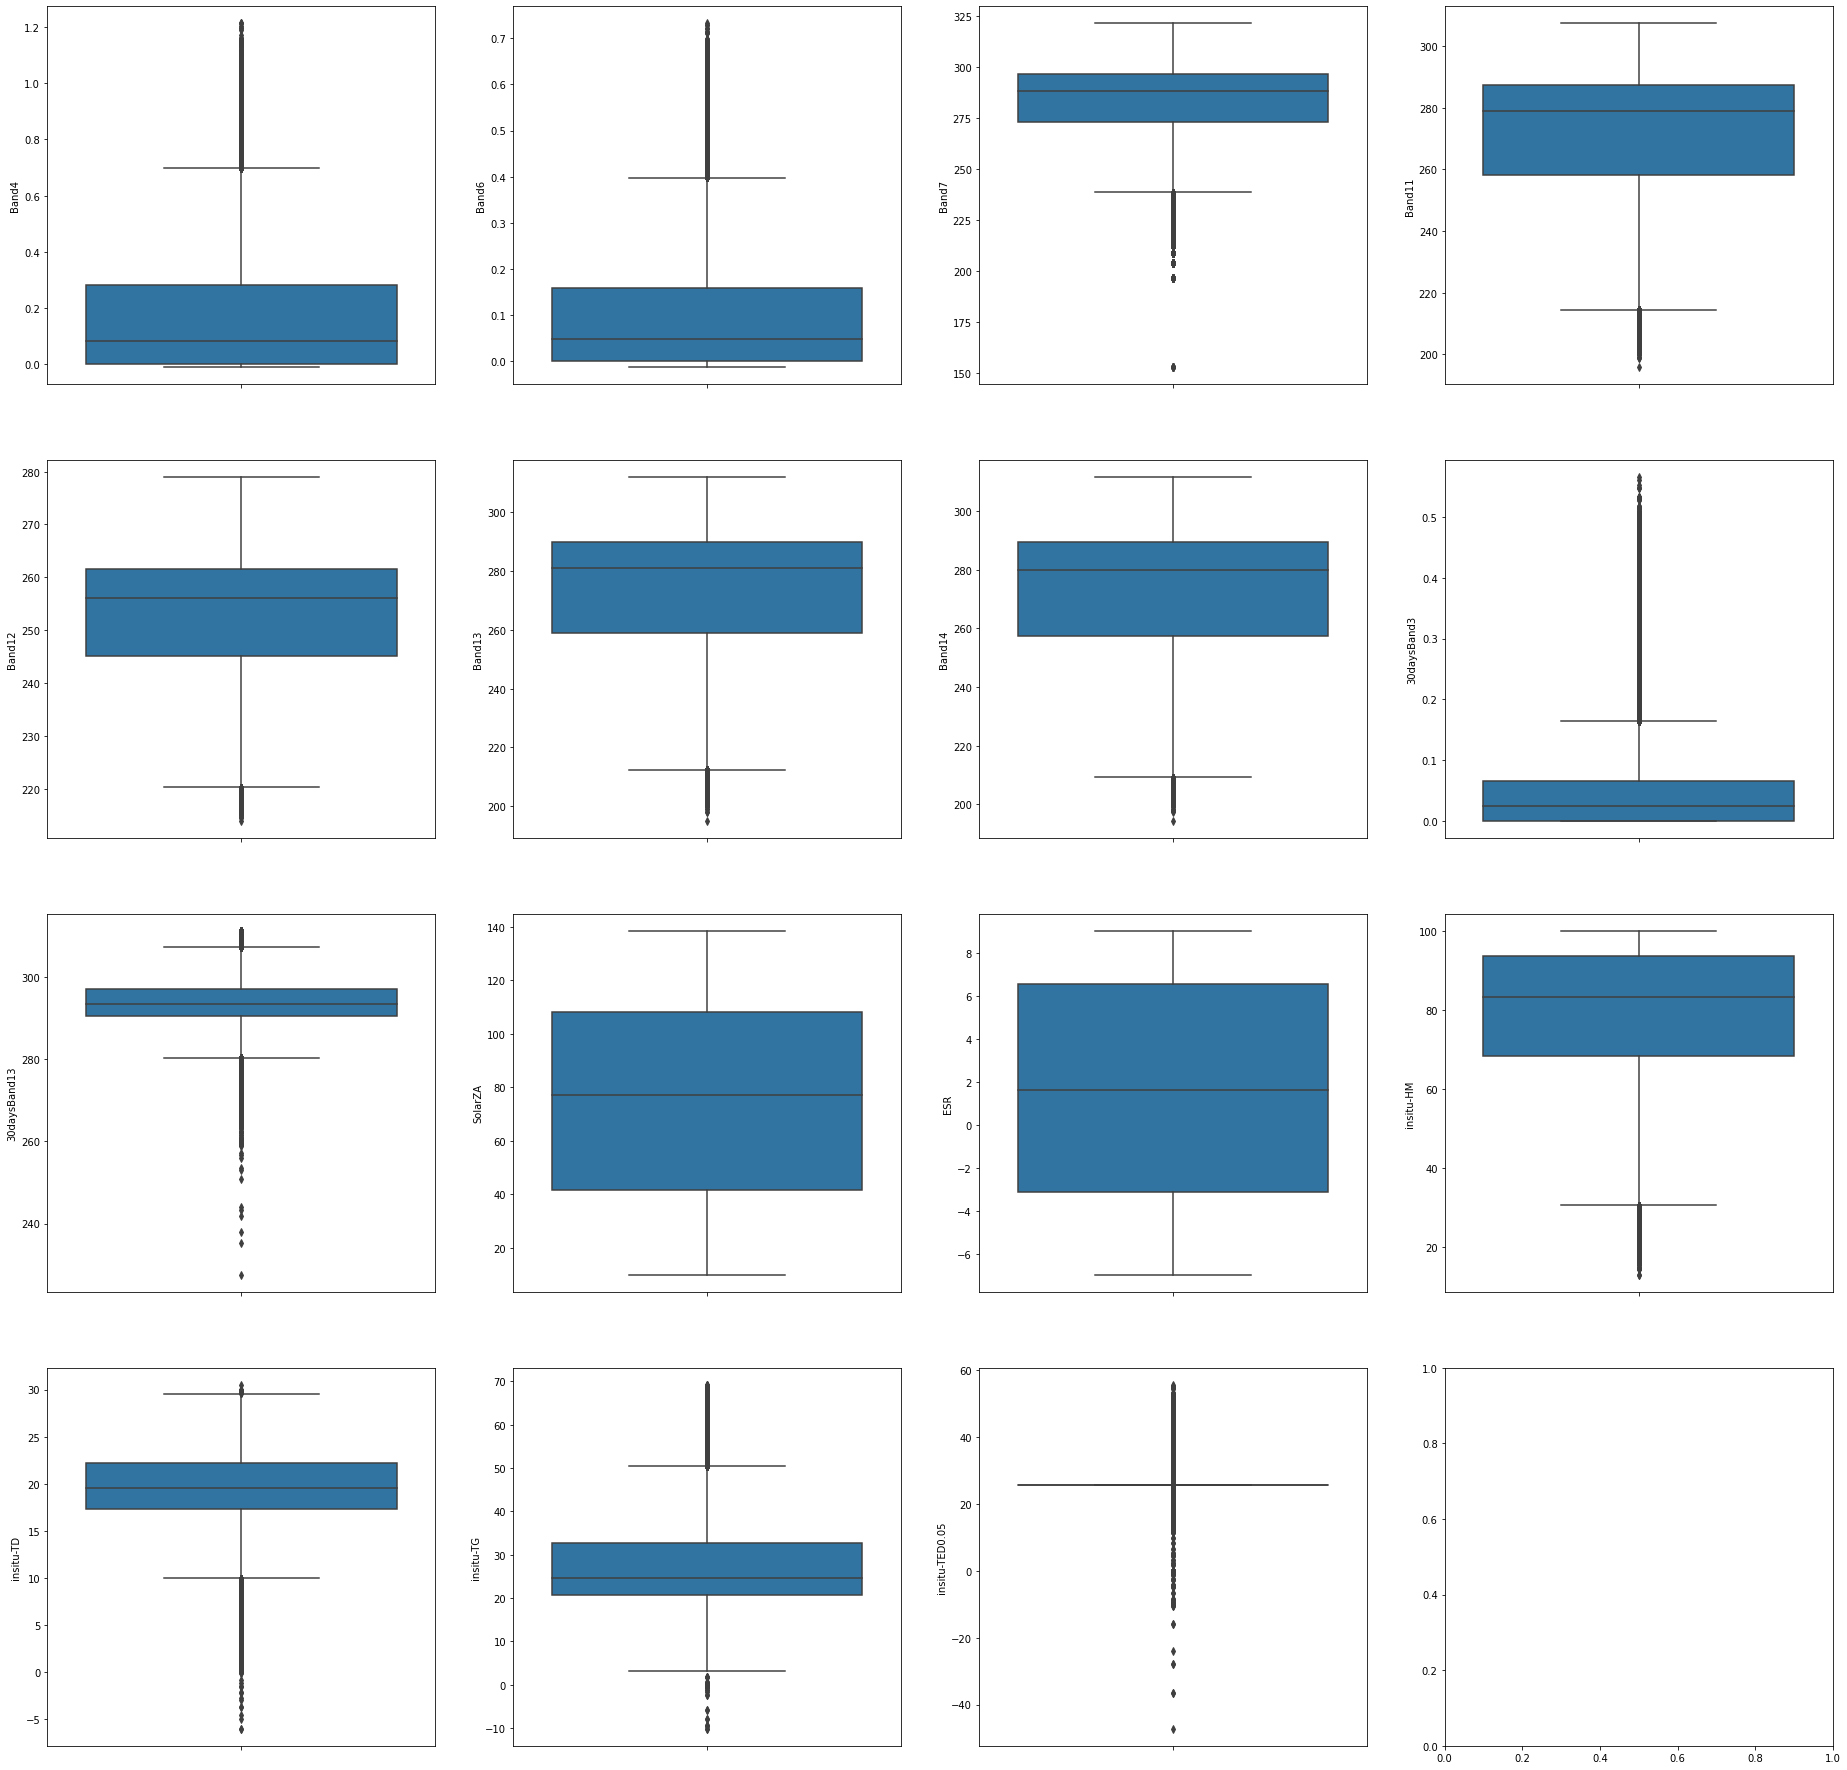

In [27]:
# 피처들 데이터 분포 확인
fig, axs = plt.subplots(figsize=(32, 32), ncols=4, nrows=4)
cat_features = ['Band4', 'Band6', 'Band7', 'Band11', 'Band12', 'Band13', 'Band14', '30daysBand3', '30daysBand13', 'SolarZA', 'ESR', 'insitu-HM', 'insitu-TD', 'insitu-TG', 'insitu-TED0.05']
for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i % 4
    sns.boxplot(y=feature, data=train, ax=axs[row][col])

In [28]:
# LST의 이상치 제거
cond1 = train['isitu-LST'] < 5
outlier_index = train[cond1].index
train.drop(outlier_index, axis=0, inplace=True)

In [29]:
# 이상치 존재하는 피처들 이상치 제거
targets = ['Band4', 'Band6', 'Band7', 'Band11', 'Band12', 'Band13', 'Band14',
          '30daysBand3', '30daysBand13', 'insitu-HM', 'insitu-TD', 'insitu-TG']
for i in targets:
    outlier_idx = get_outlier(df=train, column=i, weight=1.5)
    train.drop(outlier_idx, axis=0, inplace=True)

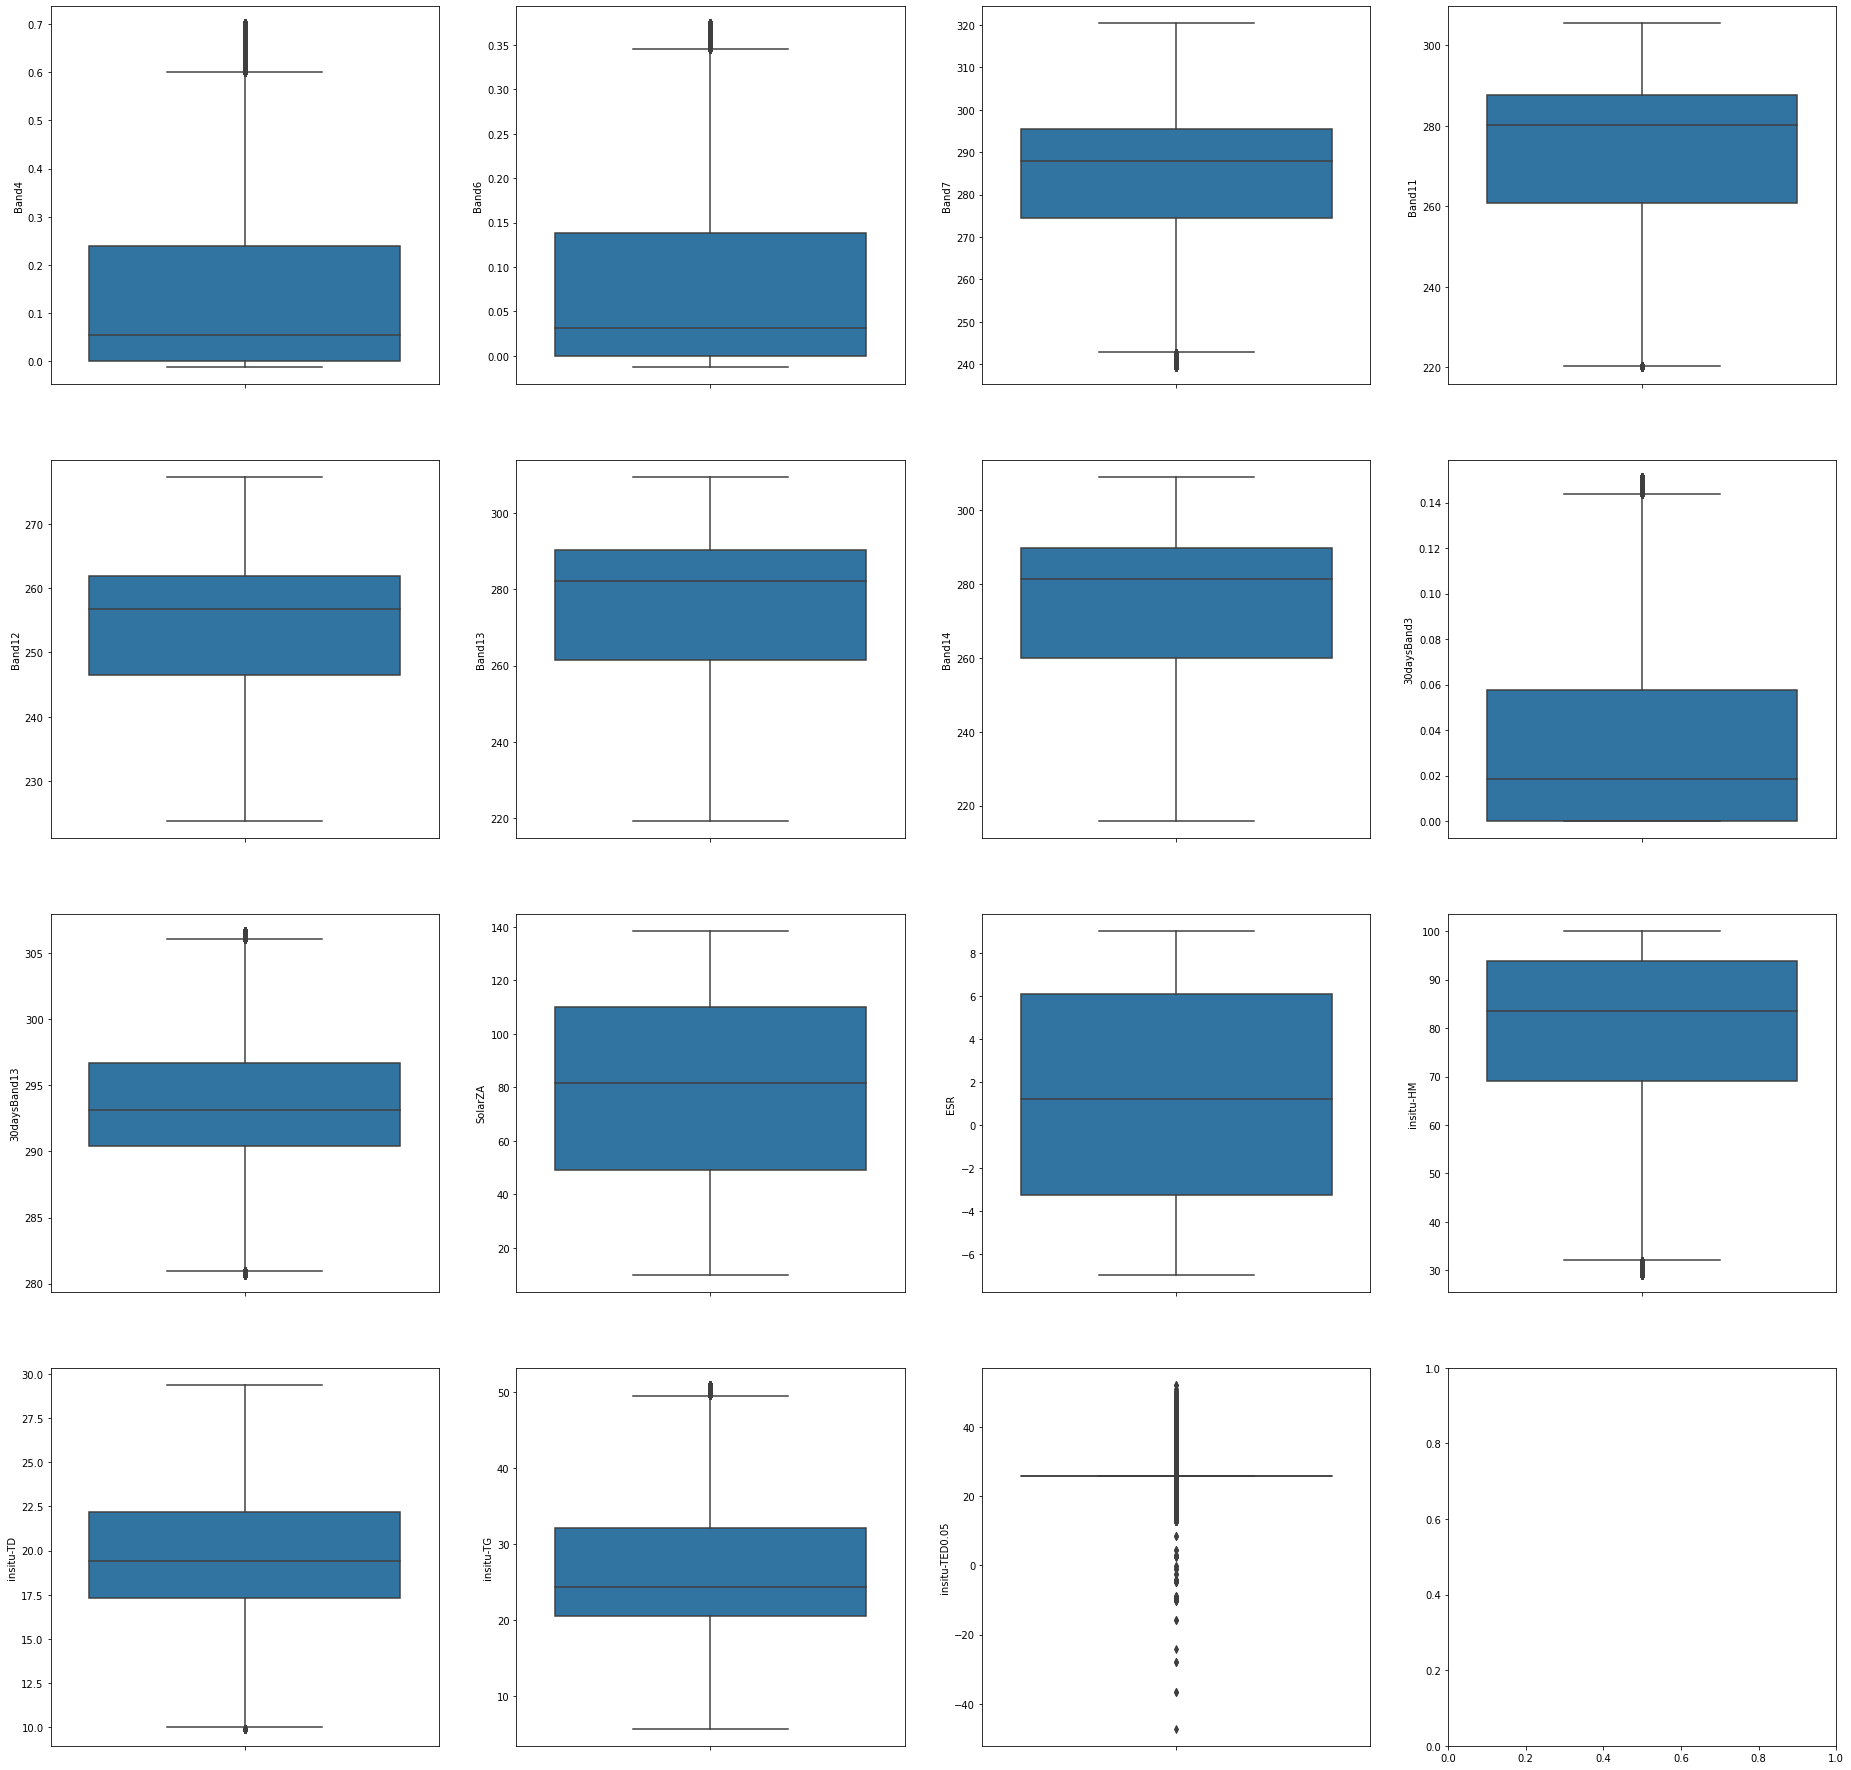

In [30]:
# 이상치 제거 후 피처들 데이터 분포 확인
fig, axs = plt.subplots(figsize=(32, 32), ncols=4, nrows=4)
cat_features = ['Band4', 'Band6', 'Band7', 'Band11', 'Band12', 'Band13', 'Band14', '30daysBand3', '30daysBand13', 'SolarZA', 'ESR', 'insitu-HM', 'insitu-TD', 'insitu-TG', 'insitu-TED0.05']
for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i % 4
    sns.boxplot(y=feature, data=train, ax=axs[row][col])

In [31]:
train.shape, test.shape

((2954189, 17), (54503, 17))

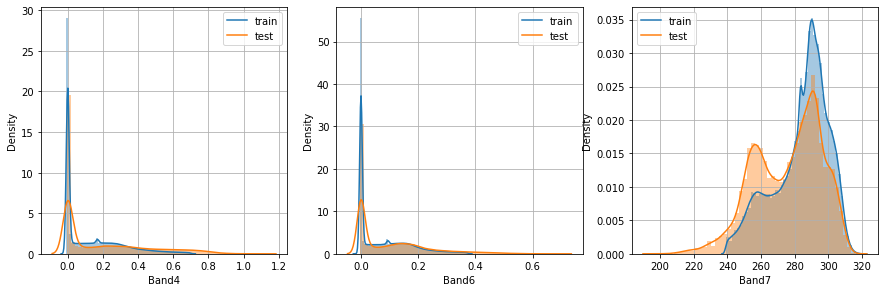

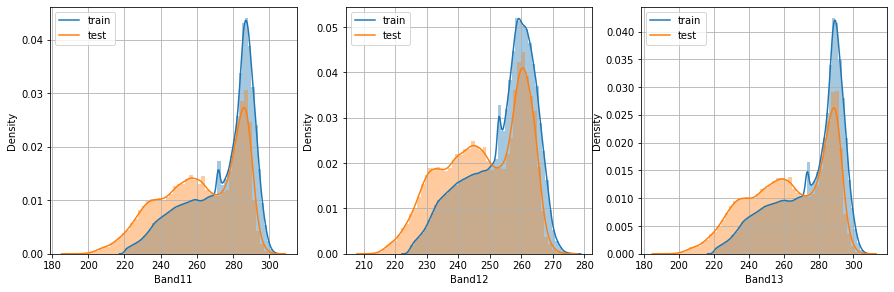

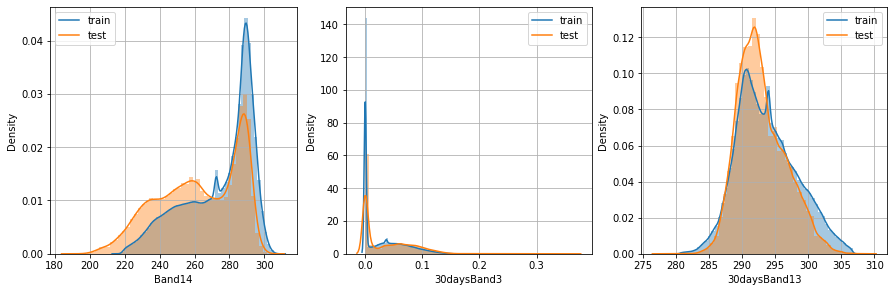

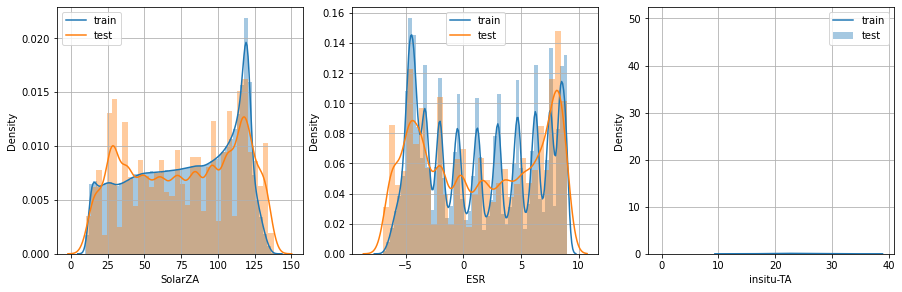

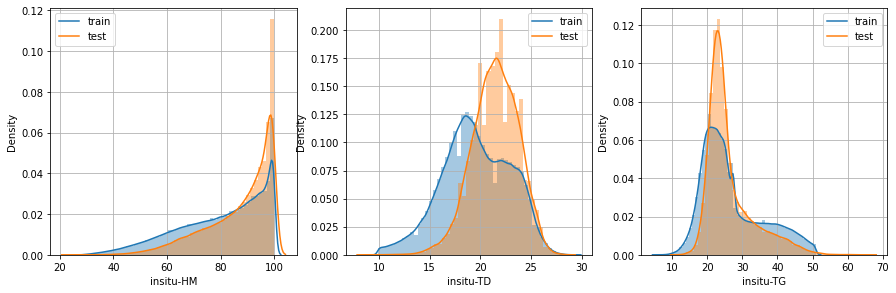

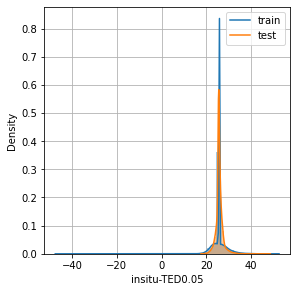

In [32]:
# train과 test 간의 데이터 분포 확인 - 오버피팅 방지
Numeric = train.copy()
del Numeric['isitu-LST']
Numeric_columns = Numeric.select_dtypes(include = ["int64","float64"]).columns

ix = 1
fig = plt.figure(figsize = (15,10))
for c in list(Numeric_columns):
    if ix <= 3:
            ax2 = fig.add_subplot(2,3,ix+3)
            sns.distplot(train[c].dropna())
            sns.distplot(test[c].dropna())
            plt.legend(['train', 'test'])
            plt.grid()            
    ix = ix +1
    if ix == 4: 
        fig = plt.figure(figsize = (15,10))
        ix =1
del Numeric

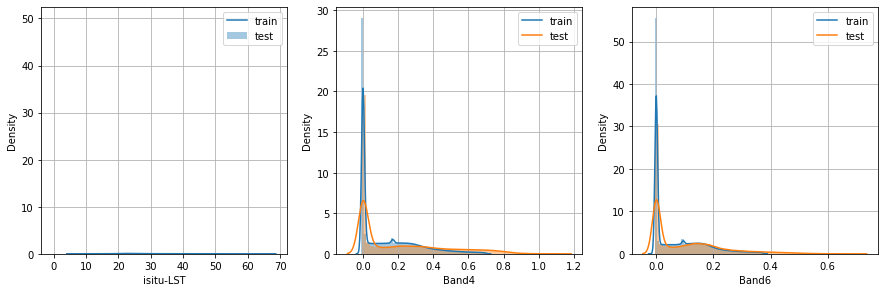

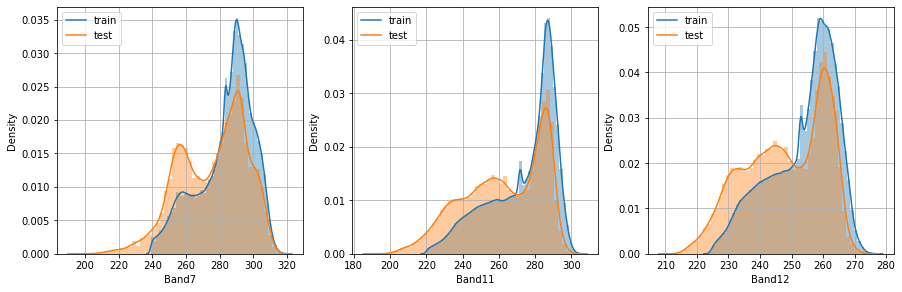

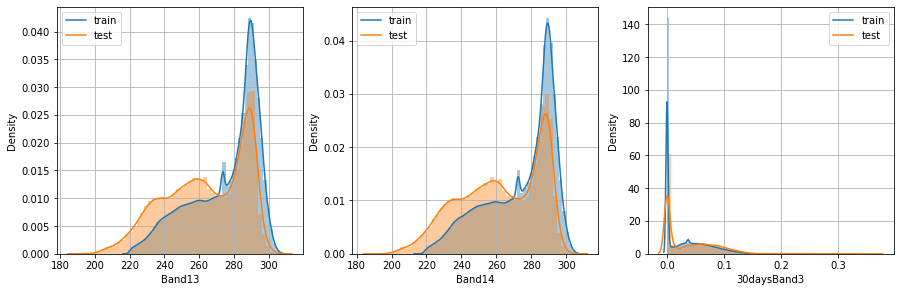

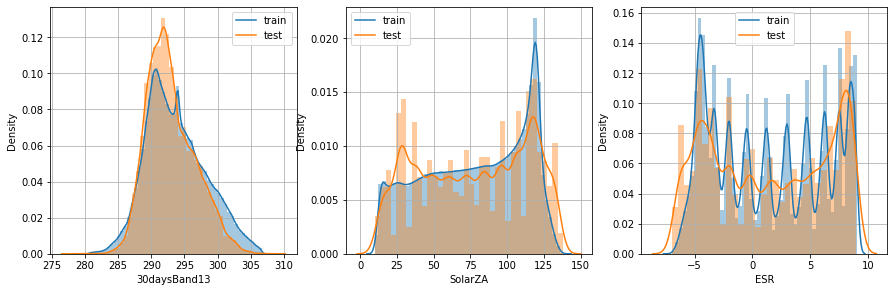

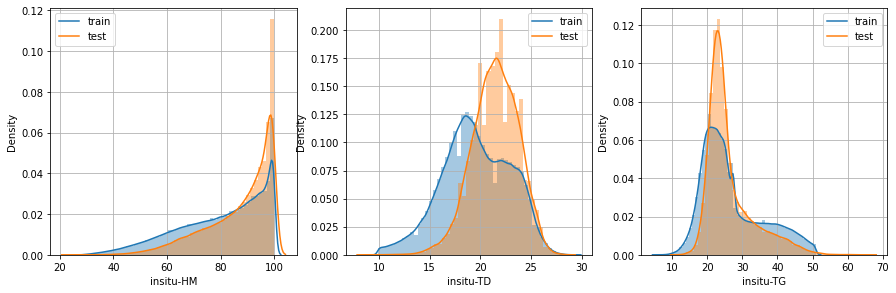

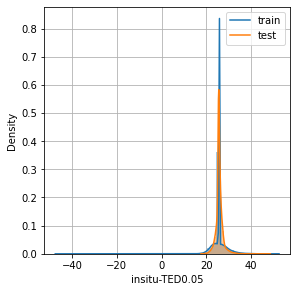

In [33]:
# train과 test 간의 데이터 분포 확인 - 오버피팅 방지
Numeric = train.copy()
del Numeric['insitu-TA']
Numeric_columns = Numeric.select_dtypes(include = ["int64","float64"]).columns

ix = 1
fig = plt.figure(figsize = (15,10))
for c in list(Numeric_columns):
    if ix <= 3:
            ax2 = fig.add_subplot(2,3,ix+3)
            sns.distplot(train[c].dropna())
            sns.distplot(test[c].dropna())
            plt.legend(['train', 'test'])
            plt.grid()            
    ix = ix +1
    if ix == 4: 
        fig = plt.figure(figsize = (15,10))
        ix =1
del Numeric

In [34]:
y_train_LST = train['isitu-LST']
x_train = train.drop(['isitu-LST', 'insitu-TA'], axis=1)
x_test = test.drop(['isitu-LST', 'insitu-TA'], axis=1)

In [75]:
model = LGBMRegressor(learning_rate=0.005, n_estimators=3000, max_depth=5, colsample_bytree=0.7)
model.fit(x_train,y_train_LST)

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.005, max_depth=5,
              n_estimators=3000)

In [76]:
pred_LST = model.predict(x_test)

In [77]:
y_train_TA = train['insitu-TA']

In [78]:
model.fit(x_train,y_train_TA)

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.005, max_depth=5,
              n_estimators=3000)

In [79]:
pred_TA = model.predict(x_test)

In [80]:
valid = pd.read_csv('/Users/namseoyong/Downloads/1-2_검증데이터셋.csv')

In [81]:
valid['isitu-LST'] = pred_LST

In [82]:
valid['insitu-TA'] = pred_TA

In [83]:
valid.to_csv('220097.csv', index=False)